In [18]:
# !pip install logging
# from dotenv import load_dotenv
# _ = load_dotenv()
#llama3-groq-70b-8192-tool-use-preview
import os
from langchain_groq import ChatGroq
import getpass
# KnowledgeGraphTool
import requests
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_core.tools import tool
import logging

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph IoT Engine"
# Load a specific environment variable
GKGraph_API_KEY = os.environ.get('GKGraph_API_KEY')
TAVILY_API_KEY=os.environ.get('TAVILY_API_KEY')
# model = ChatGroq(model="llama3-8b-8192")
llm = ChatGroq(model="llama3-8b-8192")

In [2]:
def configure_logging(debug=False):
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)
        
# Turn on debugging
configure_logging(debug=False)

In [37]:
assistant_prompt= """
Act as an assistant  and answer user queries ONLY if you can 
User queries may fall into one of the following categories:
1- Greeting/General: Greeting you or answering a general question you can ONLY answer.
2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?
3- Hard Question: General questions you can't answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don't have access to the current event happening right now
Your response must follow the following JSON  objects based on each category:
 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:
 {
 "query-type": "greeting-general",
 "response": write your response here
}
2-Service Recommendation: try to extract the service type and the city, country, Address, or Coordinates if mentioned. Your response is ONLY a JSON object. This JSON object must follow the following structure and set false in bool format for the value of the keys that you can't extract.
 { 
    "query-type": "greeting-general",
    "service": extracted service type, 
    "city": extracted city,
    "city": extracted country"
    "address": extracted address,
    "coordinates":[extracted  latitude, extracted longitude]
}
3- Hard Question/current events: you need to provide your response ONLY JSON object as shown:
 {
 "query-type": "hard-question",
}
"""



In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage,AnyMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    handled: bool= False
    make_sense: bool=False
        
# class AgentState(TypedDict):
#     messages: Annotated[list[AnyMessage], operator.add]
#     handled: bool=False
#     make_sense: bool=False

In [31]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph,StateGraph

def assistant_agent(state: AgentState):
    logging.info("entering asstiant node")
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages":[response], "handled":True,  "make_sense": None}
    
def generator_agent(state: AgentState):
    return input

def reviewer_agent(state: AgentState):
    logging.info("entering reviewer node")
    return {"messages":[HumanMessage("Hi how are You? How I can help you")],"handled":True, "make_sense":True}

def IoT_engine(state: AgentState):
    lgging.info("Using branch B")
    return input


def GoogleMaps(state: AgentState):
    logging.info("Using branch C")
    return input

def GoogleKnowledgeGraph(state: AgentState):
    logging.info("Using branch C")
    return input


def Scrapper(state: AgentState):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"

def assitant_router(state: AgentState):
    logging.info("STATE at assitant_router:", state)
    messages = state["messages"]
    last_message = messages[-1]
    logging.info(last_message)
    logging.info(state["handled"])
    if  state["handled"]:
        logging.info("@assitant_router and handled true")
        return "reviewer_agent"
    else:
        return "IoT_engine"

def reviewer_router(state: AgentState):
    logging.info("I'm in reviewer router")
    if  state["make_sense"]:
        logging.info("Make sense True at reviewer writer")
        return "END"
    else:
        return "IoT_engine"


def router(state: AgentState):
    if  state["make_sense"]:
        return "END"
    else:
        return "IoT_engine"
# graph = MessageGraph()
graph=StateGraph(AgentState)
graph.add_node("assistant_agent", assistant_agent)
graph.add_node("generator_agent", generator_agent)
graph.add_node("IoT_engine", IoT_engine)
graph.add_node("GoogleMaps", GoogleMaps)
graph.add_node("GoogleKnowledgeGraph", GoogleKnowledgeGraph)
graph.add_node("Scrapper", Scrapper)
graph.add_node("reviewer_agent", reviewer_agent)


# graph.add_edge("assistant_agent", "reviewer_agent")
# graph.add_edge("assistant_agent", "IoT_engine")

graph.add_conditional_edges(
    "assistant_agent", assitant_router, {"reviewer_agent": "reviewer_agent", "IoT_engine": "IoT_engine"}
)


graph.add_conditional_edges(
    "IoT_engine", router, {"generator_agent": "generator_agent", "GoogleMaps": "GoogleMaps"}
)

# graph.add_edge("IoT_engine", "generator_agent")
# graph.add_edge("IoT_engine", "GoogleMaps")


# graph.add_edge("GoogleMaps", "generator_agent")
# graph.add_edge("GoogleMaps", "GoogleKnowledgeGraph")
graph.add_conditional_edges(
    "GoogleMaps", router, {"generator_agent": "generator_agent", "GoogleKnowledgeGraph": "GoogleKnowledgeGraph"}
)


# graph.add_edge("GoogleKnowledgeGraph", "generator_agent")
# graph.add_edge("GoogleKnowledgeGraph", "Scrapper")
graph.add_conditional_edges(
    "GoogleKnowledgeGraph", router, {"generator_agent": "generator_agent", "Scrapper": "Scrapper"}
)

# graph.add_edge("Scrapper", "generator_agent")

graph.add_edge("generator_agent","reviewer_agent")

graph.add_conditional_edges(
    "reviewer_agent", reviewer_router, { "Scrapper": "Scrapper" ,"END":END}
)


graph.set_entry_point("assistant_agent")

runnable = graph.compile()

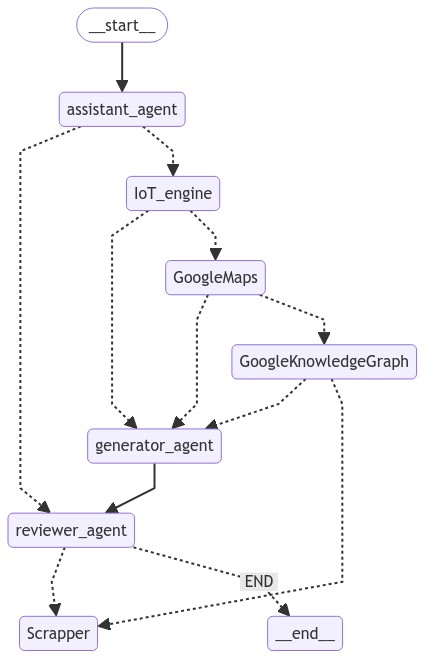

In [32]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [35]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content=assistant_prompt)
human_message = HumanMessage(content="Hi")
messages = [system_message, human_message]

result = runnable.invoke({"messages": messages, "api_call_count": 0})

INFO:root:entering asstiant node
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:STATE at assitant_router:
INFO:root:content='{\n  "query-type": "greeting-general",\n  "response": "Hello! How can I assist you today?"\n}' response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 344, 'total_tokens': 371, 'completion_time': 0.021318044, 'prompt_time': 0.070368012, 'queue_time': None, 'total_time': 0.09168605599999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None} id='run-64ceec45-3e6e-45d2-94c3-757d90d38bba-0' usage_metadata={'input_tokens': 344, 'output_tokens': 27, 'total_tokens': 371}
INFO:root:True
INFO:root:@assitant_router and handled true
INFO:root:entering reviewer node
INFO:root:I'm in reviewer router
INFO:root:Make sense True at reviewer writer


In [40]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content=assistant_prompt)
human_message = HumanMessage(content="can you suggest a place for my vecation?")
messages = [system_message, human_message]

result = runnable.invoke({"messages": messages, "api_call_count": 0})

INFO:root:entering asstiant node
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:STATE at assitant_router:
INFO:root:content='{\n    "query-type": "service-recommendation",\n    "service": "hotel",\n    "city": false,\n    "country": false,\n    "address": false,\n    "coordinates": false\n}' response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 359, 'total_tokens': 404, 'completion_time': 0.03541839, 'prompt_time': 0.055471701, 'queue_time': None, 'total_time': 0.090890091}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None} id='run-f827d0ca-ba29-44f6-bbbf-6641b7ed4382-0' usage_metadata={'input_tokens': 359, 'output_tokens': 45, 'total_tokens': 404}
INFO:root:True
INFO:root:@assitant_router and handled true
INFO:root:entering reviewer node
INFO:root:I'm in reviewer router
INFO:root:Make sense True at reviewer writer


In [25]:
for i in result["messages"]:
    print(i)

content='\nAct as an assistant  and answer user queries ONLY if you can \nUser queries may fall into one of the following categories:\n1- Greeting/General: Greeting you or answering a general question you can ONLY answer.\n2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?\n3- Hard Question: General questions you can\'t answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don\'t have access to the current event happening right now\nYour response must follow the following JSON  objects based on each category:\n 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:\n {\n "query-type": "greeting-general",\n "response": write your response here\n}\n2-Service Recommendation: try to extract the service type and the city, count

In [3]:
logging.debug("This is a debug message")
logging.info("This is an info message")
logging.warning("This is a warning message")
logging.error("This is an error message")
logging.critical("This is a critical message")

INFO:root:This is an info message
ERROR:root:This is an error message
CRITICAL:root:This is a critical message
